In [2]:
import matplotlib.pyplot as plt
import numpy as np

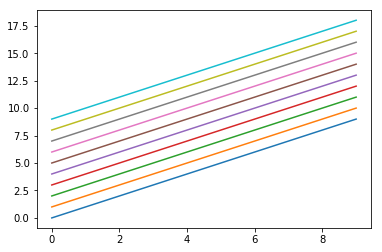

In [4]:
grid = np.arange(10).reshape(-1,1) + np.arange(10).reshape(1,-1)
plt.plot(grid)

In [12]:
def extract_lonlat(filename):
    with open(filename,"r") as f:
        for row in f:
            break
    (lat_part,lon_part) = row.split(",")

    lat = float(lat_part.split(" ")[1])
    lon = float(lon_part.split(" ")[2])
    return lon,lat
(lon0,lat0) = extract_lonlat(filename = 'colliders.csv')
print(lon0+1,lat0)

-121.39745 37.79248


In [1]:
import argparse
import time
import msgpack
from enum import Enum, auto

import numpy as np

from planning_utils import a_star, heuristic, create_grid
from udacidrone import Drone
from udacidrone.connection import MavlinkConnection
from udacidrone.messaging import MsgID
from udacidrone.frame_utils import global_to_local



In [2]:
class States(Enum):
    MANUAL = auto()
    ARMING = auto()
    TAKEOFF = auto()
    WAYPOINT = auto()
    LANDING = auto()
    DISARMING = auto()
    PLANNING = auto()


In [3]:
class MotionPlanning(Drone):

    def __init__(self, connection):
        super().__init__(connection)

        self.target_position = np.array([0.0, 0.0, 0.0])
        self.waypoints = []
        self.in_mission = True
        self.check_state = {}

        # initial state
        self.flight_state = States.MANUAL

        # register all your callbacks here
        self.register_callback(MsgID.LOCAL_POSITION, self.local_position_callback)
        self.register_callback(MsgID.LOCAL_VELOCITY, self.velocity_callback)
        self.register_callback(MsgID.STATE, self.state_callback)

    def local_position_callback(self):
        if self.flight_state == States.TAKEOFF:
            if -1.0 * self.local_position[2] > 0.95 * self.target_position[2]:
                self.waypoint_transition()
        elif self.flight_state == States.WAYPOINT:
            if np.linalg.norm(self.target_position[0:2] - self.local_position[0:2]) < 1.0:
                if len(self.waypoints) > 0:
                    self.waypoint_transition()
                else:
                    if np.linalg.norm(self.local_velocity[0:2]) < 1.0:
                        self.landing_transition()

    def velocity_callback(self):
        if self.flight_state == States.LANDING:
            if self.global_position[2] - self.global_home[2] < 0.1:
                if abs(self.local_position[2]) < 0.01:
                    self.disarming_transition()

    def state_callback(self):
        if self.in_mission:
            if self.flight_state == States.MANUAL:
                self.arming_transition()
            elif self.flight_state == States.ARMING:
                if self.armed:
                    self.plan_path()
            elif self.flight_state == States.PLANNING:
                self.takeoff_transition()
            elif self.flight_state == States.DISARMING:
                if ~self.armed & ~self.guided:
                    self.manual_transition()

    def arming_transition(self):
        self.flight_state = States.ARMING
        print("arming transition")
        self.arm()
        self.take_control()

    def takeoff_transition(self):
        self.flight_state = States.TAKEOFF
        print("takeoff transition")
        self.takeoff(self.target_position[2])

    def waypoint_transition(self):
        self.flight_state = States.WAYPOINT
        print("waypoint transition")
        self.target_position = self.waypoints.pop(0)
        print('target position', self.target_position)
        self.cmd_position(self.target_position[0], self.target_position[1], self.target_position[2], self.target_position[3])

    def landing_transition(self):
        self.flight_state = States.LANDING
        print("landing transition")
        self.land()

    def disarming_transition(self):
        self.flight_state = States.DISARMING
        print("disarm transition")
        self.disarm()
        self.release_control()

    def manual_transition(self):
        self.flight_state = States.MANUAL
        print("manual transition")
        self.stop()
        self.in_mission = False

    def send_waypoints(self):
        print("Sending waypoints to simulator ...")
        data = msgpack.dumps(self.waypoints)
        self.connection._master.write(data)

    def plan_path(self):
        self.flight_state = States.PLANNING
        print("Searching for a path ...")
        TARGET_ALTITUDE = 5
        SAFETY_DISTANCE = 5

        self.target_position[2] = TARGET_ALTITUDE

        # TODO: read lat0, lon0 from colliders into floating point values
        
        # TODO: set home position to (lon0, lat0, 0)

        # TODO: retrieve current global position
 
        # TODO: convert to current local position using global_to_local()
        
        print('global home {0}, position {1}, local position {2}'.format(self.global_home, self.global_position,
                                                                         self.local_position))
        # Read in obstacle map
        data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)
        
        # Define a grid for a particular altitude and safety margin around obstacles
        grid, north_offset, east_offset = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
        print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))
        # Define starting point on the grid (this is just grid center)
        grid_start = (-north_offset, -east_offset)
        # TODO: convert start position to current position rather than map center
        
        # Set goal as some arbitrary position on the grid
        grid_goal = (-north_offset + 10, -east_offset + 10)
        # TODO: adapt to set goal as latitude / longitude position and convert

        # Run A* to find a path from start to goal
        # TODO: add diagonal motions with a cost of sqrt(2) to your A* implementation
        # or move to a different search space such as a graph (not done here)
        print('Local Start and Goal: ', grid_start, grid_goal)
        path, _ = a_star(grid, heuristic, grid_start, grid_goal)
        
        # TODO: prune path to minimize number of waypoints
        # TODO (if you're feeling ambitious): Try a different approach altogether!

        # Convert path to waypoints
        waypoints = [[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in path]
        # Set self.waypoints
        self.waypoints = waypoints
        # TODO: send waypoints to sim
        self.send_waypoints()

    def start(self):
        self.start_log("Logs", "NavLog.txt")

        print("starting connection")
        self.connection.start()

        # Only required if they do threaded
        # while self.in_mission:
        #    pass

        self.stop_log()


In [ ]:
#if __name__ == "__main__":
parser = argparse.ArgumentParser()

In [ ]:
parser.add_argument('--port', type=int, default=5760, help='Port number')

In [ ]:
parser.add_argument('--host', type=str, default='127.0.0.1', help="host address, i.e. '127.0.0.1'")

In [ ]:
args = parser.parse_args()

In [ ]:
%tb

In [6]:
conn = MavlinkConnection('tcp:127.0.0.1:5760', timeout=60)

In [7]:
drone = MotionPlanning(conn)

Logs/TLog.txt


In [8]:
time.sleep(1)

In [9]:
drone.start()

Logs/NavLog.txt
starting connection
arming transition
Searching for a path ...
global home [-122.39745   37.79248    0.     ], position [-122.39745     37.7924816    0.165    ], local position [ 0.18457605 -0.00058904 -0.16552639]
North offset = -316, east offset = -445
Local Start and Goal:  (316, 445) (326, 455)
Found a path.
Sending waypoints to simulator ...
takeoff transition
waypoint transition
target position [0, 0, 5, 0]
waypoint transition
target position [0, 1, 5, 0]
waypoint transition
target position [1, 1, 5, 0]
waypoint transition
target position [1, 2, 5, 0]
waypoint transition
target position [2, 2, 5, 0]
waypoint transition
target position [2, 3, 5, 0]
waypoint transition
target position [3, 3, 5, 0]
waypoint transition
target position [3, 4, 5, 0]
waypoint transition
target position [4, 4, 5, 0]
waypoint transition
target position [4, 5, 5, 0]
waypoint transition
target position [5, 5, 5, 0]
waypoint transition
target position [5, 6, 5, 0]
waypoint transition
target p